# Car Prices

# Objective
The primary goal of this analysis is to understand the factors that influence the sale price of the cars. Specifically, which factors drive the car prices up and develop a model to accurately predict the sale price based on the car's features.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import normaltest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Dataset
This analysis uses the car sales dataset from Kaggle (https://www.kaggle.com/datasets/goyalshalini93/car-data), which contains all the information about cars, a name of a manufacturer, all car's technical parameters and a sale price of a car.

In [2]:
# Load the dataset (ensure the CSV file is in your working directory)
data = pd.read_csv("data/CarPrice_Assignment.csv")

In [3]:
# Display basic information about the dataset
print("Dataset Information:")
print(data.info())

print("\nDescriptive Statistics:")
print(data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 n

# Data Cleaning and Wrangling

First, we check if we have any missing values and duplicates.

In [4]:
# Check for missing values
data.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [5]:
# Check for duplicates (unique car_ID)
sum(data.duplicated(subset = 'car_ID')) == 0

True

Let's see how the cars are distributed for each brand.

'CarName' includes both the company name (brand) and the car model. We want to split a company name from the model of a car, as for our model building purpose, we will focus on a company name only.

In [6]:
# Split brand and model
data['brand'] = data.CarName.str.split(' ').str.get(0).str.lower()
data.brand.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [7]:
# Correct typos in car names
data['brand'] = data['brand'].replace(['vw', 'vokswagen'], 'volkswagen')
data['brand'] = data['brand'].replace(['maxda'], 'mazda')
data['brand'] = data['brand'].replace(['porcshce'], 'porsche')
data['brand'] = data['brand'].replace(['toyouta'], 'toyota')
data.brand.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [8]:
# Drop 'car_ID', 'symboling', and 'CarName' from our data frame, since they are longer be needed
data.drop(['car_ID', 'symboling', 'CarName'],axis = 1, inplace = True)

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/4091458970.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plt1 = sns.countplot(data['brand'], order = pd.value_counts(data['brand']).index,)


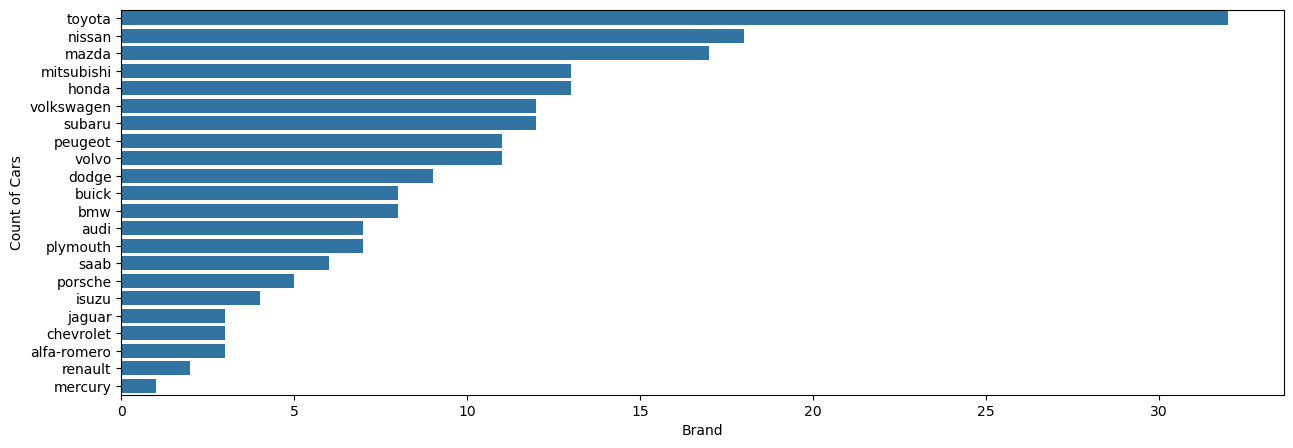

<Figure size 640x480 with 0 Axes>

In [9]:
# Count of cars
fig, ax = plt.subplots(figsize = (15,5))
plt1 = sns.countplot(data['brand'], order = pd.value_counts(data['brand']).index,)
plt1.set(xlabel = 'Brand', ylabel = 'Count of Cars')
plt.show()
plt.tight_layout()

# Exploratory Data Analysis

We use a boxplot on categorical variables, to display the mean, variance, and possible outliers, with respect to the price.

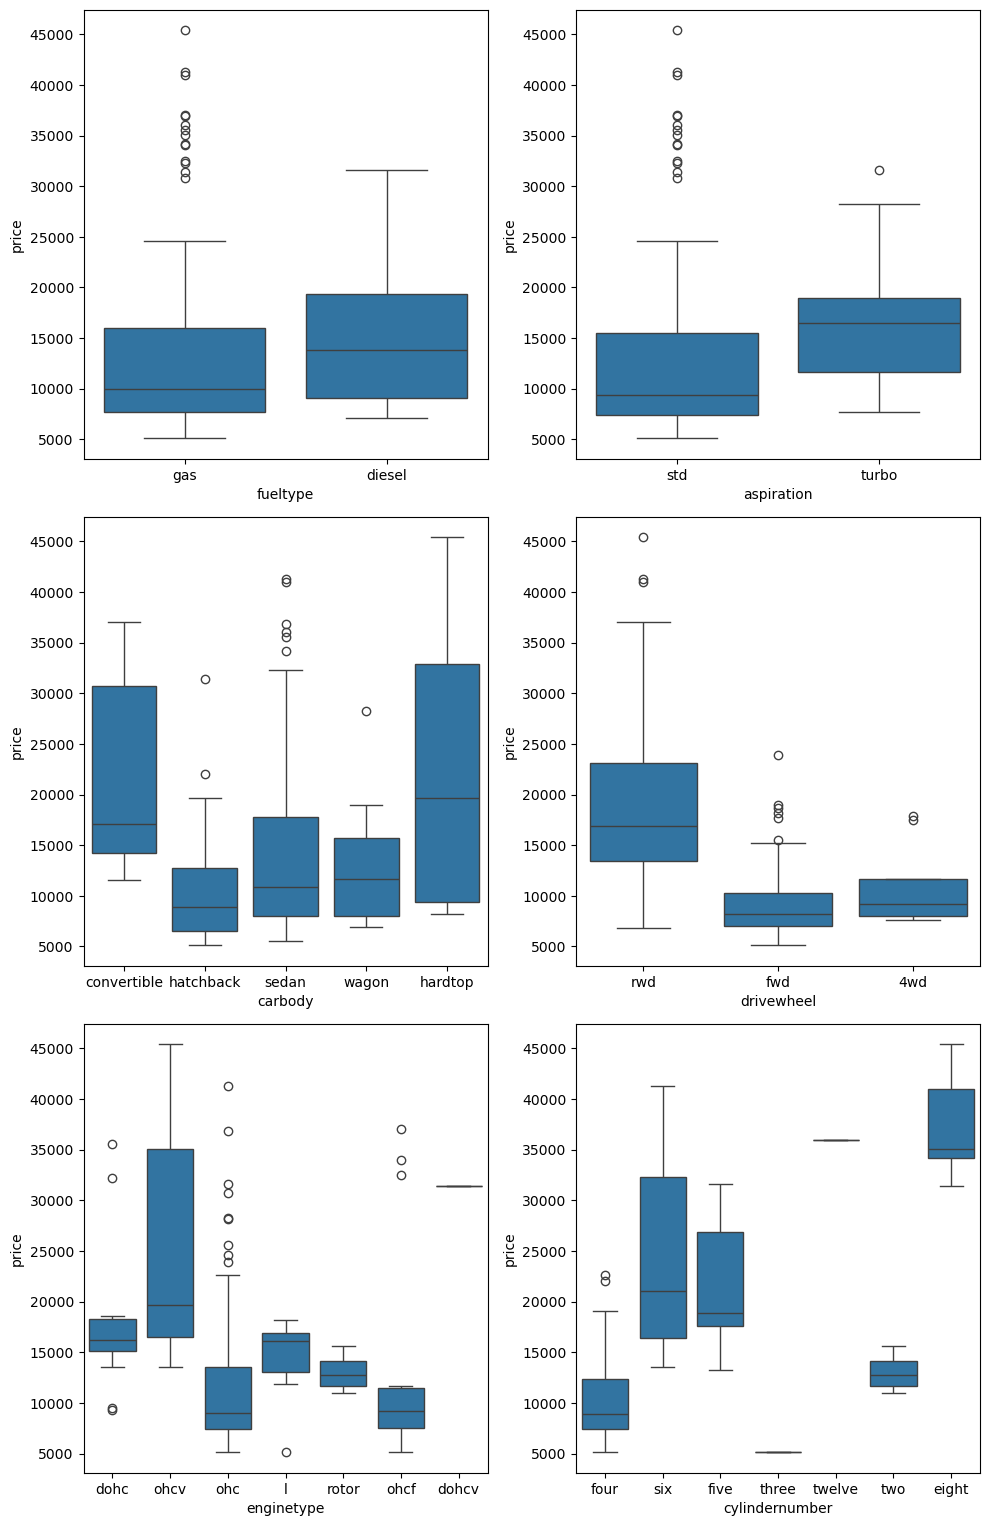

In [10]:
# Boxplot
plt.figure(figsize=(10, 20))
plt.subplot(4,2,1)
sns.boxplot(x = 'fueltype', y = 'price', data = data)
plt.subplot(4,2,2)
sns.boxplot(x = 'aspiration', y = 'price', data = data)
plt.subplot(4,2,3)
sns.boxplot(x = 'carbody', y = 'price', data = data)
plt.subplot(4,2,4)
sns.boxplot(x = 'drivewheel', y = 'price', data = data)
plt.subplot(4,2,5)
sns.boxplot(x = 'enginetype', y = 'price', data = data)
plt.subplot(4,2,6)
sns.boxplot(x = 'cylindernumber', y = 'price', data = data)
plt.tight_layout()
plt.show()

Next, let's view the list of top features that have high correlation coefficient.

Also pairplot to further explore the relationship between all features and the target variables.

In [11]:
# Correlation matrix
corr_matrix = data.corr(numeric_only = True)
corr_matrix['price'].sort_values(ascending = False)

price               1.000000
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

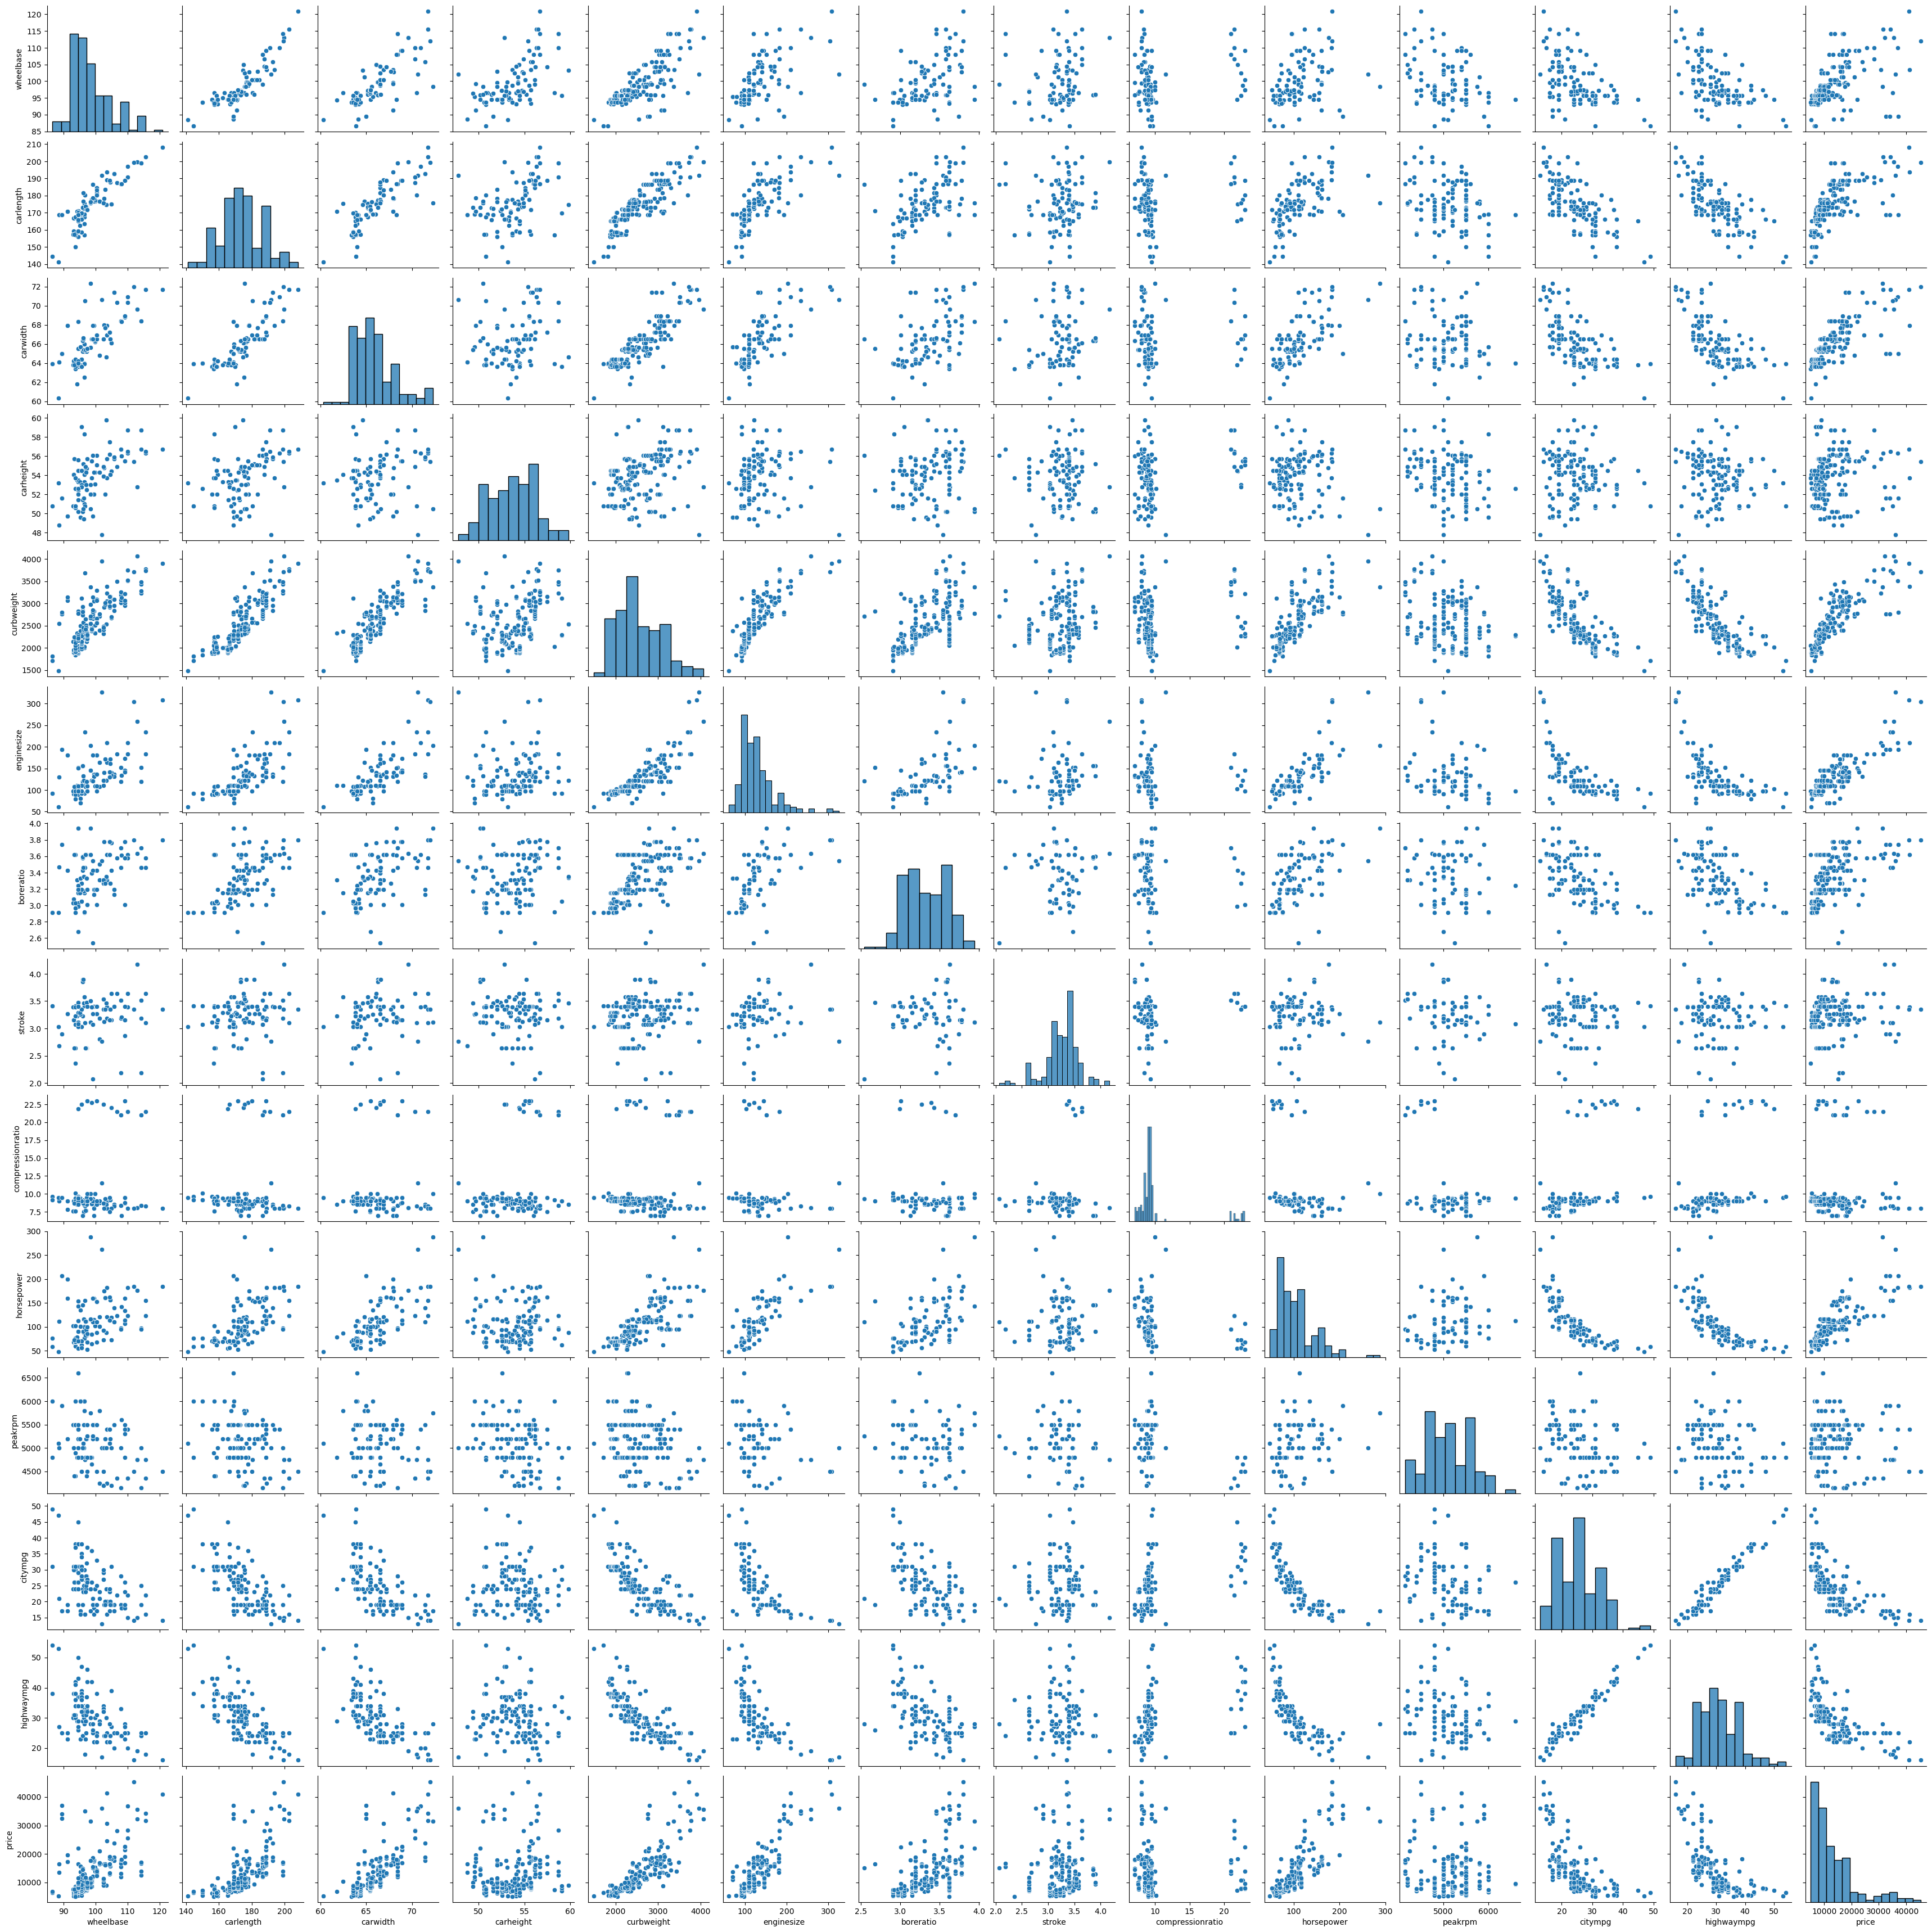

In [12]:
# Pairplot
sns.pairplot(data)
plt.show()

# Modeling

<b>Linear Regression<b>

First, we fit a Linear Regression model. This assumes that the relationship between the target (price) and other features is linear. 

The linear regression analysis requires the dependent variable, 'price', to be normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed. The goodness of fit test, e.g., the Kolmogorov-Smirnov test can check for normality in the dependent variable.

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/1406905448.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.loc[:,feature], norm_hist = True, ax = ax1)


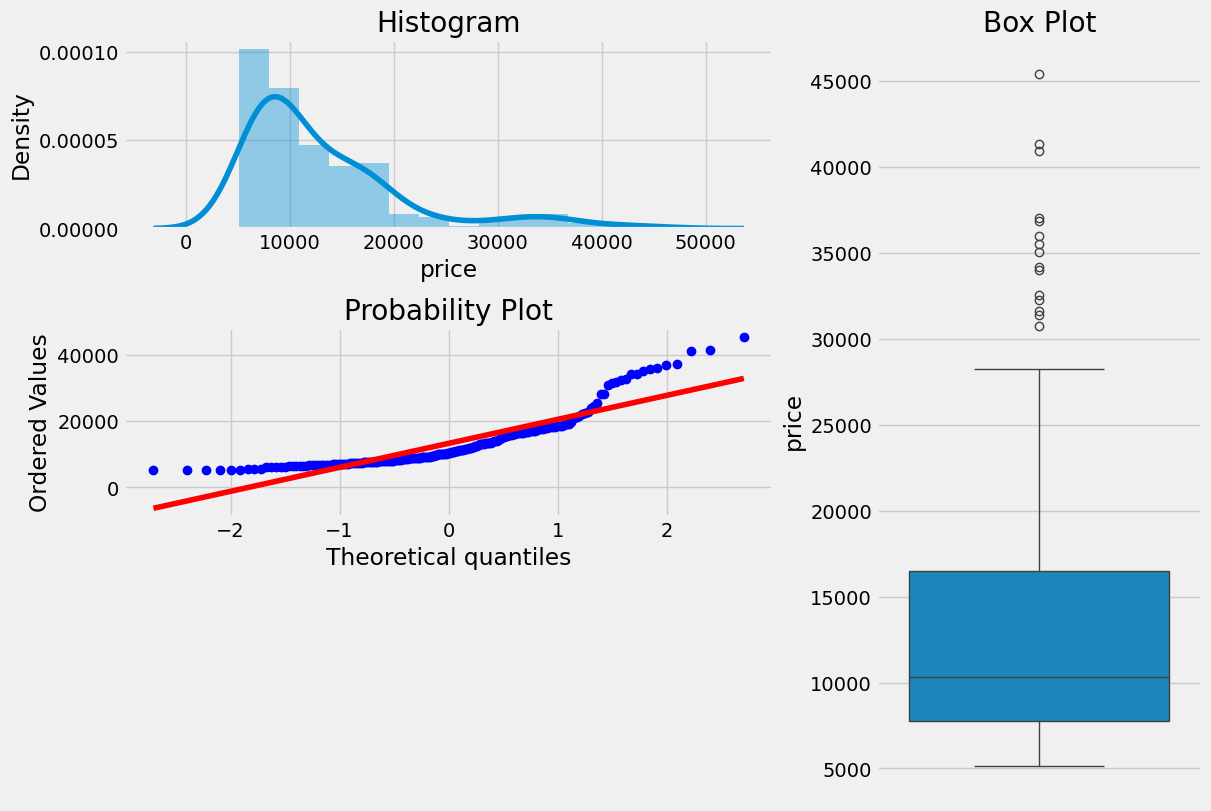

In [13]:
# Normality check plots
def plotting_3_chart(data, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout = True, figsize = (12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(data.loc[:,feature], norm_hist = True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(data.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(data.loc[:,feature], orient = 'v', ax = ax3);
    
plotting_3_chart(data, 'price')

In [14]:
# Normality test
normaltest(data.price.values)

NormaltestResult(statistic=77.37514013383584, pvalue=1.578344501676757e-17)

From the three charts above:

- Our target variable, 'price' is not normally distributed.
- Our target variable is right-skewed,
- There are some outliers in the variable.

The right-skewed plot means that most prices in the dataset are on the lower end (below 15000). The 'max' value is very far from the '75%' quantile statistic. All these plots show that the assumption for accurate linear regression modeling is not met.

We also check statistically if the target is normally distributed, using 'normaltest()' function. If the p-value is large (>0.05), the target variable is normally distributed. The p-value is very small, so it is not normally distributed.

Now, we can try to transform our data, so it looks more normally distributed.

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/1406905448.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.loc[:,feature], norm_hist = True, ax = ax1)


NormaltestResult(statistic=14.10341345775947, pvalue=0.0008659297880185564)

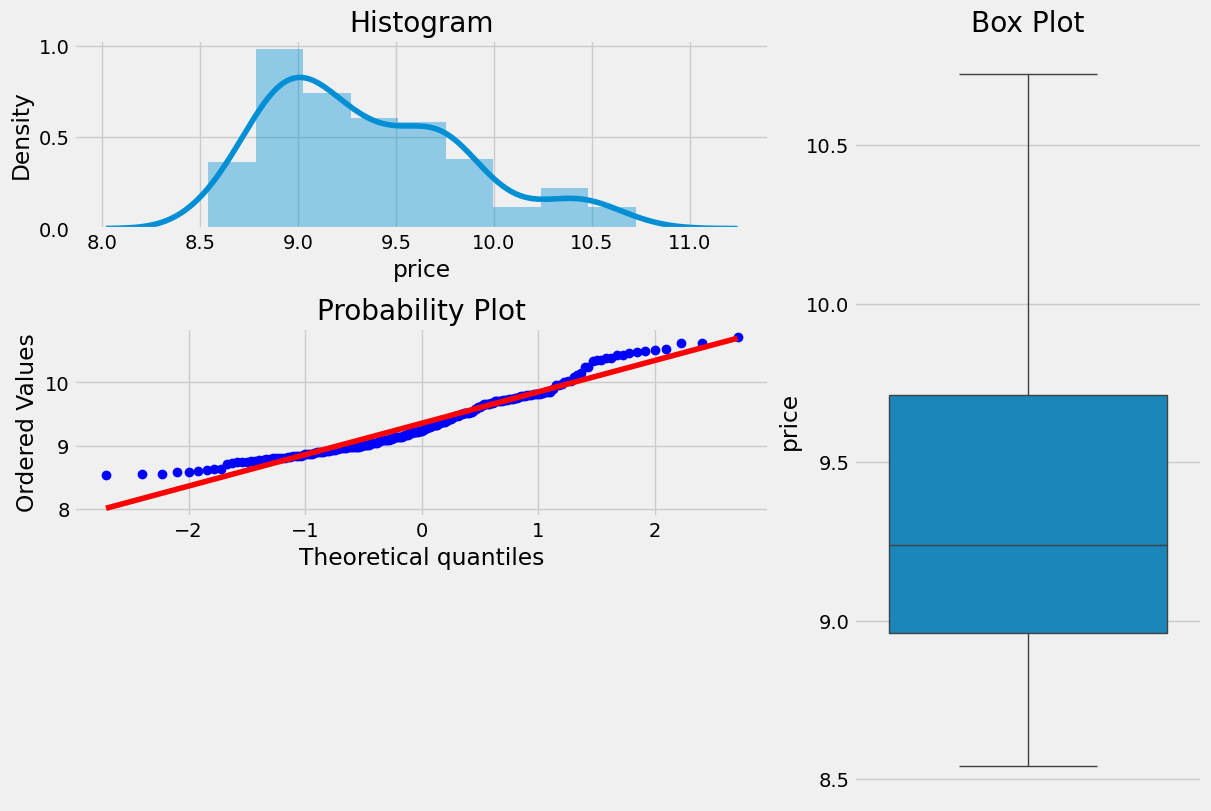

In [15]:
# Log-transform and normality test
data['price'] = np.log(data['price'])
plotting_3_chart(data, 'price')

normaltest(data.price.values)

As we can see, the log method transformed the car 'price' distribution into a more symmetrical bell curve. It is still not perfect, but it is much closer to being normally distributed.

Multicollinearity is when there is a strong correlation between the independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:
- The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.
- Predictors can have widely different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects.
- We can no longer interpret a coefficient on a variable because there is no scenario in which one variable can change without a conditional change in another variable.

Using 'heatmap()' function is an excellent way to identify whether there is multicollinearity present or not. The best way to solve for multicollinearity is to use the regularization methods like Ridge or Lasso.

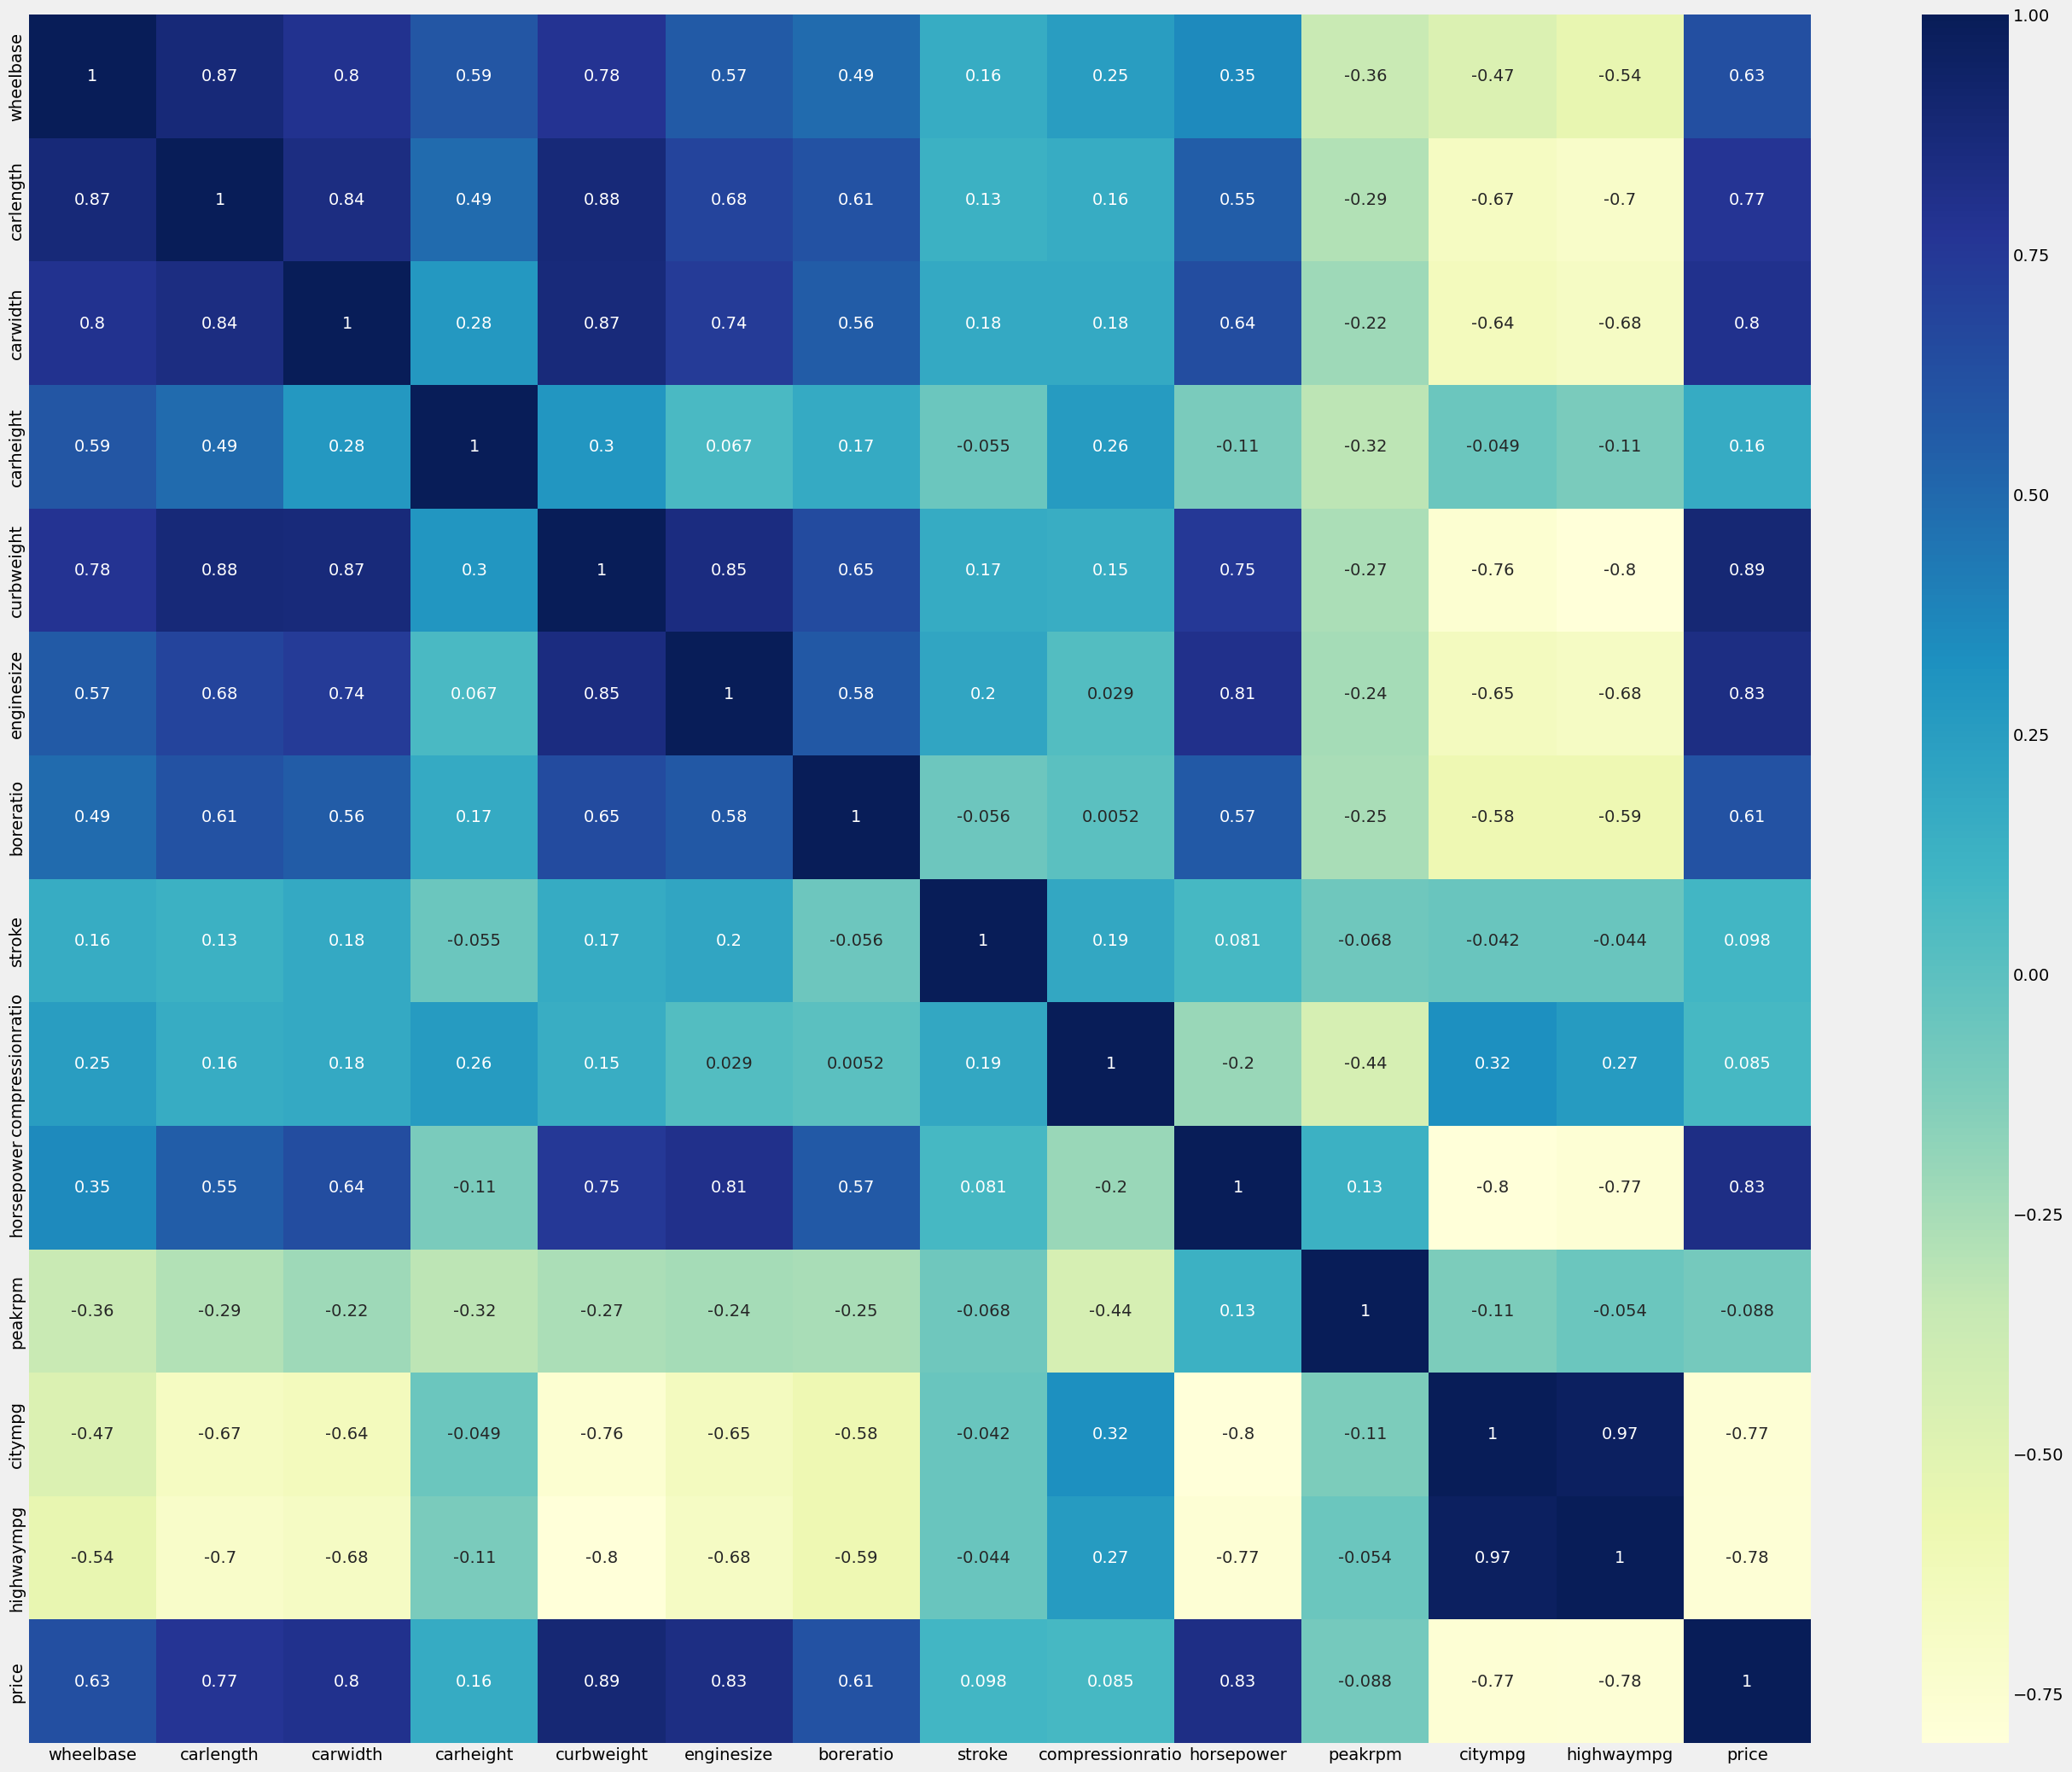

In [16]:
# Multicollinearity check
num = data.select_dtypes(include = ['int64', 'float64'])
plt.figure(figsize = (30, 25))
sns.heatmap(num.corr(), annot = True, cmap = "YlGnBu")
plt.show()

As we can see, the multicollinearity still exists in various features. However, we keep them for now and let the models (e.g. regularization models such as Lasso, Ridge) do the clean up later on.

We put all the selected features into a data frame. Then split into categorical and numeric variables. Categorical variables need to be one-hot encoded for modelling.

In [17]:
columns = ['price', 'fueltype', 'aspiration','carbody', 'drivewheel','wheelbase',
                  'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio', 'horsepower', 'carlength', 'carwidth', 'citympg', 'highwaympg']
selected = data[columns]

# Separate categorical and numeric columns
categorical_columns = selected.select_dtypes(include = 'object').columns.tolist()
numeric_columns = selected.select_dtypes(exclude = 'object').columns.tolist()

In [18]:
# Split the data into the features X and target y
X = selected.drop("price", axis = 1)
y = selected["price"].copy()

In [19]:
# One-hot enconding categorical variables
one_hot = ColumnTransformer(transformers = [("one_hot", OneHotEncoder(), categorical_columns)], remainder = "passthrough")
X = one_hot.fit_transform(X)

# Save the result as a dataframe
names = one_hot.get_feature_names_out()
colunm_names = [name[name.find("_")+1:] for name in  [name[name.find("__")+2:] for name in names]]
X = pd.DataFrame(data = X, columns = colunm_names)

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

We standardize features by removing the mean and scaling to unit variance.

In [21]:
# Standardization
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Finally, we apply the linear regression model.

In [22]:
# Linear regression model
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

<b>Evaluation<b>

In [23]:
# Predictions
y_pred = lm.predict(X_test)

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/476423859.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist = False, color = "r", label = "Actual Value")
/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/476423859.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

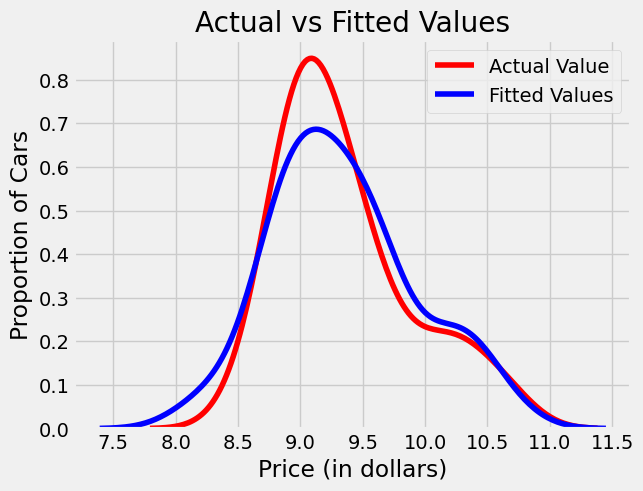

In [24]:
# Plot true values vs predictions
plt.figure()
ax1 = sns.distplot(y_test, hist = False, color = "r", label = "Actual Value")
sns.distplot(y_pred, hist = False, color = "b", label = "Fitted Values" , ax = ax1)
plt.legend()
plt.title('Actual vs Fitted Values')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')
plt.show()
plt.close()

Let's evaluate this model with some statistics. We use the mean squared error (MSE), which measures the average of the squares of the errors, that is, the average squared difference between the estimated values and the actual values using the test data.

In [25]:
mean_squared_error(y_test, y_pred)

0.028009219600523994

Checking the R squared, the coefficient of determination, which is the proportion of the variation in the dependent variable that is predictable from the independent variables. The closer is R squared to 1, the better is the fit of the model.

In [26]:
r2_score(y_test, y_pred)

0.8967689080038184

<b>Polynomial Regression<b>

We explore Polynomial Regression and perform polynomial transform.

First, let's visualize some of the relationships between our features and the target variable, 'price'. The relationships are more curved than a simple straight line.

In [27]:
# Restore log-transformation for visualization
data = pd.DataFrame(data = X, columns = colunm_names)
data['price'] = np.exp(y)

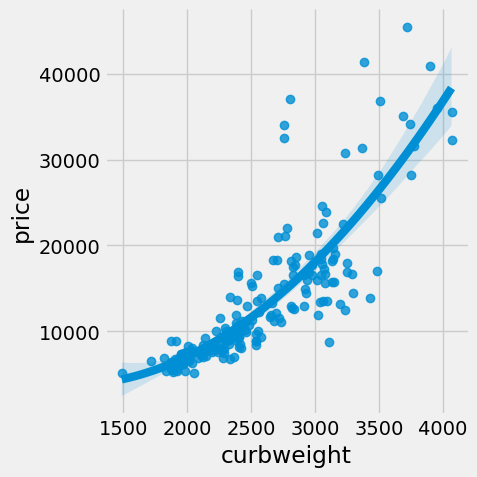

In [29]:
sns.lmplot(x = 'curbweight', y = 'price', data = data, order = 2)

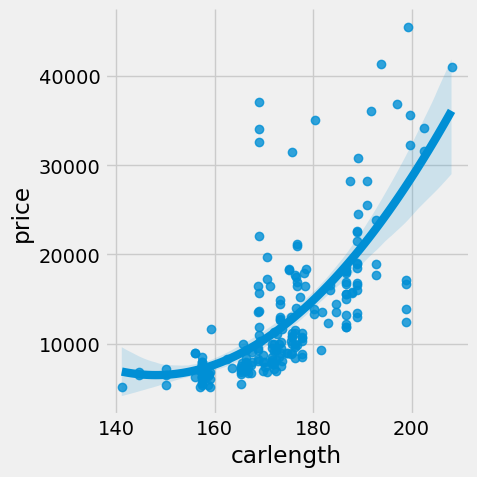

In [30]:
sns.lmplot(x = 'carlength', y = 'price', data = data, order = 2)

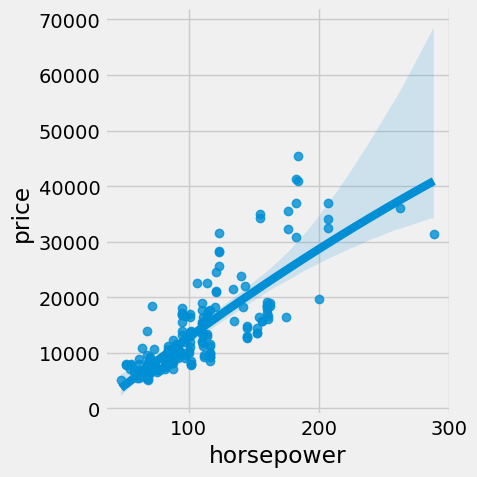

In [31]:
sns.lmplot(x = 'horsepower', y = 'price', data = data, order = 2)

In [32]:
# Train-test split
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Polynomial transform is a simple way to increase the complexity of the model, but we must be mindful of overfitting.

We define a pipeline object, then use GridSearch to find the best hyper-parameters of the model by using cross-validation method of the parameter grid.

In [33]:
# Pipeline
Input = [('scaler', StandardScaler()), ('polynomial', PolynomialFeatures()), ('model', LinearRegression())]
pipe = Pipeline(Input)
param_grid = {
    "polynomial__degree": [1, 2, 3]   
}
search = GridSearchCV(pipe, param_grid, n_jobs = -1)

In [34]:
# Fit
search.fit(X_train, y_train)
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.76954201937203
best_params_:  {'polynomial__degree': 1}


In [35]:
# R^2 score
best = search.best_estimator_
best.score(X_test, y_test)

0.8837274580650162

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/1415970045.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist = False, color = "r", label = "Actual Value")
/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/1415970045.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

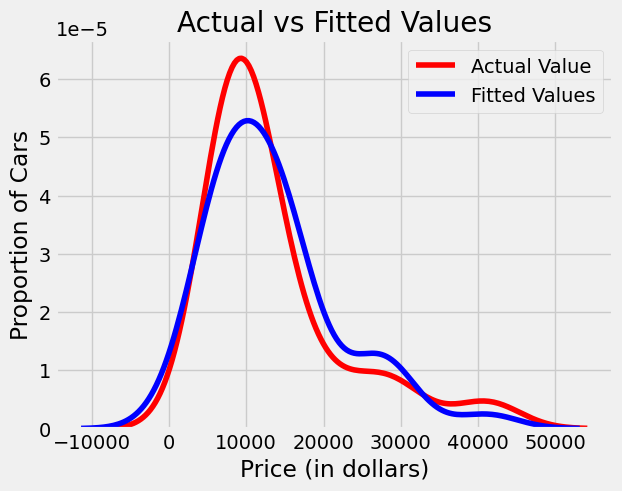

In [36]:
# Predictions
y_pred = best.predict(X_test)

# Plot true values vs predictions
plt.figure()
ax1 = sns.distplot(y_test, hist = False, color = "r", label = "Actual Value")
sns.distplot(y_pred, hist = False, color = "b", label = "Fitted Values", ax = ax1)
plt.legend()
plt.title('Actual vs Fitted Values')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')
plt.show()
plt.close()

The object finds the best parameter values on the validation data. However, the best result so far is a degree = 1 polynomial tranformation similar to the Linear Regression model we began with. This is due to the fact that including higher degree polynomial transformation likely results in overfitting.

<b>Regularization<b>

The purpose of regularization techniques is to reduce the degree of overfitting that can occur in regression models. Overfitting leads to poor ability of the model to make predictions on the new, unseen data. The creation of extra features, such as through polynomial regression, can make a model easily overfit. To reduce the overfitting, we can regularize the model, or in other words, we can decrease its degrees of freedom. A simple way to regularize polynomial model is to reduce the number of polynomial degrees. For a linear regression model, regularization is typically achieved by constraining the weights of the model. Regularizer imposes a penalty on the size of the coefficients of the model.

We cover three types of regularizers:

- Ridge regression
- Lasso regression
- Elastic Net

Each one has its own advantages and disadvantages. Ridge will reduce the impact of the features that are not important in predicting the target. Lasso will eliminate many features and reduce overfitting in the linear model. Elastic Net combines feature coefficient reduction from the Ridge model and feature elimination from Lasso to improve model’s predictions.

The common features of all these regularizers include using cross-validation to select hyperparameters and applying data normalization to improve the performance.

In [37]:
# Ridge regression
Input=[('polynomial', PolynomialFeatures()), ('ss', StandardScaler()), ('model', Ridge(tol = 0.2))]
pipe = Pipeline(Input)
param_grid = {
    "polynomial__degree": [1,2,3,4,5],
    "model__alpha": [0.0001,0.001,0.01,0.1,1,10]
}
search = GridSearchCV(pipe, param_grid, n_jobs = -1)
search.fit(X_train, y_train)
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.8691156985716276
best_params_:  {'model__alpha': 10, 'polynomial__degree': 2}


In [38]:
best = search.best_estimator_
best.score(X_test, y_test)

0.9093130839438401

In [39]:
# Lasso regression
Input=[('polynomial', PolynomialFeatures()), ('ss', StandardScaler()), ('model', Lasso(tol = 0.2))]
pipe = Pipeline(Input)
param_grid = {
    "polynomial__degree": [1,2,3,4,5],
    "model__alpha": [0.0001,0.001,0.01,0.1,1,10]
}

search = GridSearchCV(pipe, param_grid, n_jobs = -1)
search.fit(X_train, y_train)
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.7628742816458508
best_params_:  {'model__alpha': 10, 'polynomial__degree': 3}


In [40]:
best = search.best_estimator_
best.score(X_test, y_test)

0.898803588110635

In [41]:
# ElasticNet
Input=[('polynomial', PolynomialFeatures()), ('ss', StandardScaler() ), ('model', ElasticNet(tol = 0.2))]
pipe = Pipeline(Input)
param_grid = {
    "polynomial__degree": [1,2,3,4,5],
    "model__alpha": [0.0001,0.001,0.01,0.1,1,10],
    "model__l1_ratio": [0.1,0.25,0.5,0.75,0.9]
}
search = GridSearchCV(pipe, param_grid, n_jobs = -1)
search.fit(X_train, y_train)
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.8877750504012638
best_params_:  {'model__alpha': 10, 'model__l1_ratio': 0.25, 'polynomial__degree': 3}


In [42]:
best = search.best_estimator_
best.score(X_test, y_test)

0.9131429897040761

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/1415970045.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist = False, color = "r", label = "Actual Value")
/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_997/1415970045.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

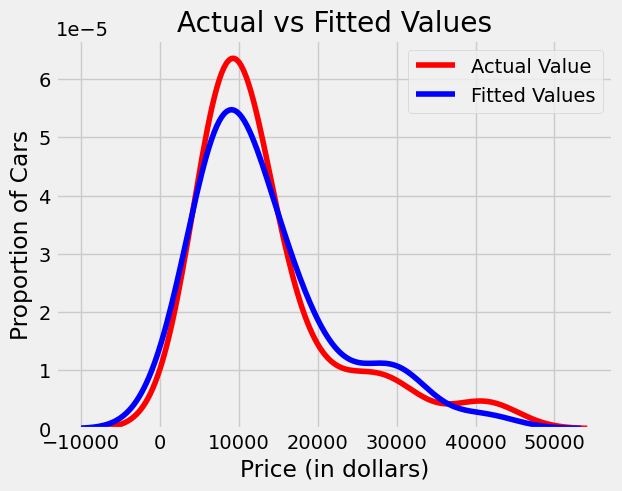

In [43]:
# Predictions
y_pred = best.predict(X_test)

# Plot true values vs predictions
plt.figure()
ax1 = sns.distplot(y_test, hist = False, color = "r", label = "Actual Value")
sns.distplot(y_pred, hist = False, color = "b", label = "Fitted Values", ax = ax1)
plt.legend()
plt.title('Actual vs Fitted Values')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')
plt.show()
plt.close()

# Conclusion

Adding polynomial features combined with regularization terms finds a better performing model avoiding overfitting in the unseen test set when compared to the simple Linear Regression model.